[Git link](https://github.com/Hyun-s/SW-AI/blob/master/Deep_learning/lab_transfer_learning/lab_05_transfer_learning.ipynb)  
[Dataset Link](https://www.kaggle.com/puneet6060/intel-image-classification)

In [ ]:
from google.colab import drive 
drive.mount('/content/mydrive')

In [ ]:
!mkdir /content/data

In [ ]:
!unzip /content/mydrive/MyDrive/SW_DL/transfer_learning_dataset.zip -d /content/data

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

In [ ]:
batch_size= 16  #1
learning_rate = 0.0001
epoch = 15

n_node = 128  # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5   # 얼마나 드랍시킬지 inverse keepratio 

imgsize = 256

In [ ]:
train_path = '/content/data/train'
val_path = '/content/data/val'
test_path = '/content/data/test'

In [ ]:
train_data = dset.ImageFolder(train_path, transforms.Compose([      
            # ①(512)③②RCrop  <-- Best !!
            transforms.CenterCrop(imgsize*2),     # ① CenterCrop(512)
            transforms.RandomCrop(imgsize),       # ③ RandomCrop
            transforms.RandomHorizontalFlip(),    # ② RandomHorizontalFlip
    
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

3126


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
# 2. Dev data
dev_data = dset.ImageFolder(val_path, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)


# 3. Test data
test_data = dset.ImageFolder(test_path, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
test_batch = data.DataLoader(test_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)
        
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d," %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

# for imgs, labels in train_batch:
#     for j in range(len(imgs)):
#         img = transforms.ToPILImage()(imgs[j])
#         plt.title("label: %d" % labels[j])
#         plt.imshow(img)
#         plt.show()

# of classes: 6
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
3126
Training: 3126, Dev: 900, Test: 900,


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


(None,)

In [ ]:
vgg = models.vgg19(pretrained=True)

for name,module in vgg.named_children():
    print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU

In [ ]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0 = nn.Sequential(*list(vgg.children())[0])  # [0]: features(conv), [1]: classifier(fc)
        self.layer1 = nn.Sequential(
            nn.Linear((8*base_dim * fsize * fsize), n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),  # 0.3 만큼 drop 하자.
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        # weight initialization
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)  # REUL 일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self, x):
        #print(x.size())  # layer0의 사이즈를 무식하게 프린트 하여 알아낼 수 있음(batchsize, x,x,x)
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

In [21]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [22]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [23]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate)

In [24]:
for img, label in train_batch:
    img = Variable(img, volatile=True).cuda()
    label = Variable(label).cuda()
    
    output = model(img)
    # output = model.layer0(img)
    # output = model.layer1(output)
    # print(output.size())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [25]:
import sys, os
sys.path.append('/content/mydrive/MyDrive/SW_DL')
import utils

total_time = 0
disp_step = 10

to_train = True
if (to_train==False):
    netname = '/content/mydrive/MyDrive/SW_DL/transfer_vgg19_50.pkl'
    model = torch.load(netname)
else:   
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" 
          %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = '/content/mydrive/MyDrive/SW_DL/transfer_vgg19.pkl'

    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습을 재시작한다면
#     netname = '../nets/media_pre_vgg19.pkl'
#     model = torch.load(netname)
#     # 파라미터 학습 여부 결정
#     for params in model.layer0.parameters():
#         params.required_grad = False    
#     for params in model.layer1.parameters():
#         params.required_grad = True
#     for i in range(34, epoch):
    
    # 재시작하지 않는 다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()

            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output,label)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step == 0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            # train, dev, train accr
            model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, " 
                  %(train_corr, dev_corr, test_corr)),
            model.train()            
            print("time: %.2f sec.." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node: 128, dropratio: 0.50
Correct of train: 18.36, dev: 21.67, test: 22.00
0..

[0/15] loss: 1.883, 
Correct of train: 56.81, dev: 65.89, test: 63.78, 
time: 60.13 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/15] loss: 0.969, 
Correct of train: 80.71, dev: 82.67, test: 84.11, 
time: 685.36 sec..
11..
12..
13..
14..

[14/15] loss: 0.378, 
Correct of train: 82.95, dev: 88.00, test: 85.67, 
time: 935.84 sec..
Total time: 935.84 sec


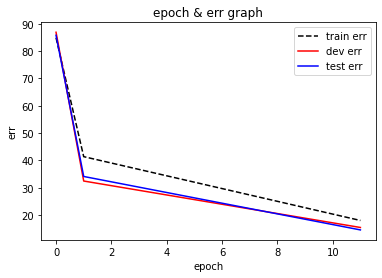

In [ ]:
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

Normalized confusion matrix


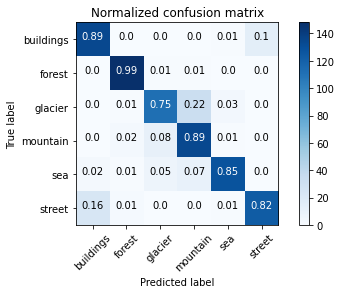

Confusion matrix, without normalization


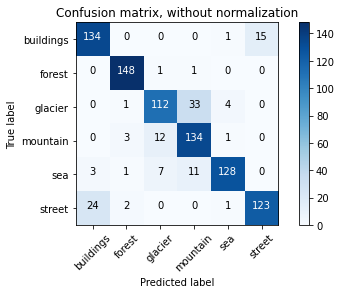

	 acc  |	 pre  |	 rec  |	 f1
 buildings: 0.95 |	 0.83 |	 0.89 |	 0.86
 forest: 0.94 |	 0.95 |	 0.99 |	 0.97
 glacier: 0.88 |	 0.85 |	 0.75 |	 0.79
 mountain: 0.87 |	 0.75 |	 0.89 |	 0.81
 sea: 0.92 |	 0.95 |	 0.85 |	 0.90
 street: 0.95 |	 0.89 |	 0.82 |	 0.85
*accuracy: 0.92, precision: 0.87, recall: 0.87, *f1 score: 0.87
[AP]
buildings: 0.93
forest: 1.00
glacier: 0.89
mountain: 0.88
sea: 0.96
street: 0.93

[mAP] 0.933
[miAP] 0.972


(array([0, 1, 2, 0, 4, 4, 5, 5, 4, 2, 4, 3, 2, 3, 1, 4, 1, 3, 2, 5, 1, 0,
        4, 4, 0, 0, 4, 3, 5, 5, 2, 3, 3, 5, 4, 3, 5, 1, 3, 3, 4, 0, 4, 3,
        5, 1, 0, 5, 3, 0, 4, 1, 1, 3, 2, 0, 2, 3, 5, 0, 1, 2, 0, 2, 1, 1,
        2, 2, 3, 4, 0, 2, 3, 2, 1, 3, 1, 4, 2, 1, 5, 0, 4, 4, 3, 3, 0, 4,
        5, 3, 3, 4, 1, 0, 1, 2, 4, 1, 3, 5, 5, 5, 3, 3, 2, 4, 5, 0, 4, 0,
        0, 2, 2, 1, 2, 0, 1, 2, 4, 0, 1, 3, 5, 3, 1, 3, 0, 2, 3, 4, 1, 4,
        2, 3, 0, 2, 2, 3, 0, 1, 4, 0, 3, 0, 1, 1, 1, 5, 4, 2, 1, 4, 3, 3,
        5, 2, 3, 3, 1, 4, 3, 3, 1, 1, 0, 1, 3, 5, 2, 1, 0, 4, 4, 1, 3, 3,
        5, 3, 2, 1, 2, 4, 2, 3, 2, 1, 1, 1, 4, 3, 2, 2, 0, 3, 4, 0, 0, 1,
        1, 0, 0, 0, 2, 1, 5, 2, 1, 0, 2, 5, 5, 0, 5, 5, 4, 5, 5, 0, 2, 3,
        1, 3, 5, 5, 2, 0, 4, 5, 1, 1, 5, 5, 4, 3, 1, 1, 0, 5, 4, 2, 1, 1,
        5, 0, 4, 0, 0, 5, 1, 5, 2, 3, 2, 3, 1, 3, 4, 4, 1, 3, 0, 0, 3, 2,
        4, 0, 0, 4, 4, 3, 2, 1, 5, 0, 5, 0, 2, 3, 0, 1, 5, 0, 0, 1, 2, 2,
        5, 5, 1, 2, 5, 0, 5, 4, 2, 5, 

In [ ]:
model.eval()   # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


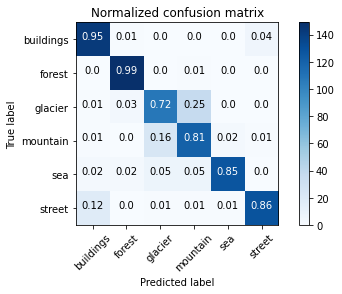

Confusion matrix, without normalization


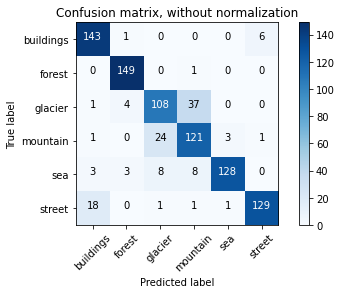

	 acc  |	 pre  |	 rec  |	 f1
 buildings: 0.97 |	 0.86 |	 0.95 |	 0.91
 forest: 0.96 |	 0.95 |	 0.99 |	 0.97
 glacier: 0.88 |	 0.77 |	 0.72 |	 0.74
 mountain: 0.87 |	 0.72 |	 0.81 |	 0.76
 sea: 0.94 |	 0.97 |	 0.85 |	 0.91
 street: 0.97 |	 0.95 |	 0.86 |	 0.90
*accuracy: 0.93, precision: 0.87, recall: 0.86, *f1 score: 0.86
[AP]
buildings: 0.95
forest: 0.98
glacier: 0.83
mountain: 0.84
sea: 0.98
street: 0.96

[mAP] 0.923
[miAP] 0.969


In [ ]:
model.eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: buildings
 True predicted images/total buildings category: 143 / 150
Predicted probability:
[0.5516359  0.00388775 0.00340951 0.0022139  0.0050974  0.43375552]


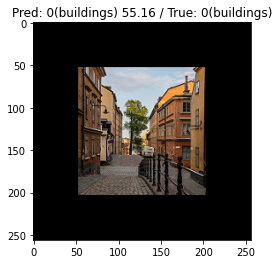

Predicted probability:
[0.7942193  0.00370925 0.01223648 0.00772917 0.02838992 0.15371586]


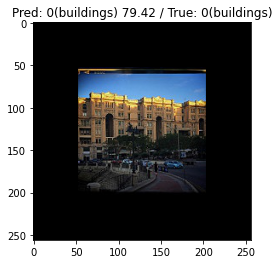

 False predicted images/total buildings category: 7 / 150
Predicted probability:
[0.346902   0.04674753 0.11489999 0.09048624 0.04294983 0.3580144 ]


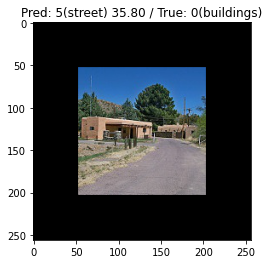

Predicted probability:
[0.32426533 0.00995216 0.02146472 0.0125237  0.01112913 0.62066495]


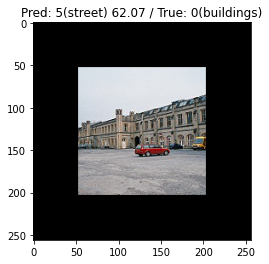

Category: forest
 True predicted images/total forest category: 149 / 150
Predicted probability:
[0.00379952 0.9404304  0.02486478 0.0193944  0.0049971  0.0065138 ]


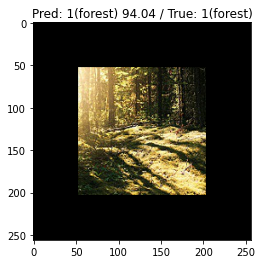

Predicted probability:
[0.01238504 0.94204706 0.01335183 0.00838842 0.00543298 0.01839468]


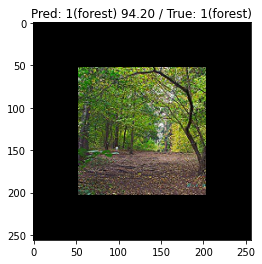

 False predicted images/total forest category: 1 / 150
Predicted probability:
[0.09333181 0.08952537 0.22320664 0.25790387 0.24277338 0.09325892]


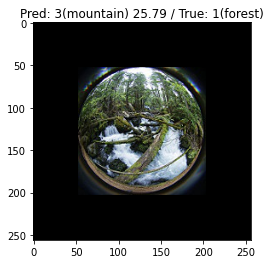

Category: glacier
 True predicted images/total glacier category: 108 / 150
Predicted probability:
[0.00222428 0.00350276 0.5778154  0.40102163 0.01237929 0.00305663]


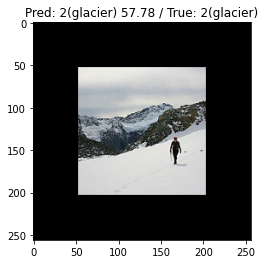

Predicted probability:
[0.00616166 0.00779045 0.4853681  0.47431573 0.01953318 0.00683087]


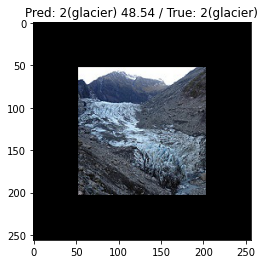

 False predicted images/total glacier category: 42 / 150
Predicted probability:
[0.00805381 0.01336759 0.43823853 0.5146452  0.01883111 0.00686376]


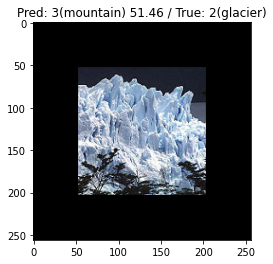

Predicted probability:
[0.02102817 0.05864073 0.3690536  0.49494275 0.04020201 0.01613273]


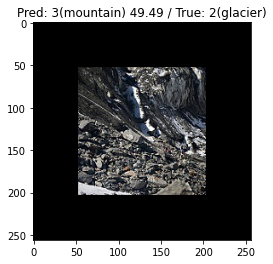

Category: mountain
 True predicted images/total mountain category: 121 / 150
Predicted probability:
[0.00619023 0.00619701 0.27997825 0.6916958  0.0109629  0.00497584]


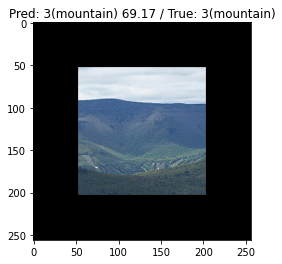

Predicted probability:
[0.00360897 0.00421571 0.17886749 0.80474985 0.00626031 0.00229767]


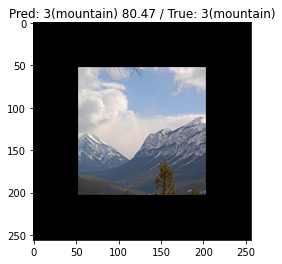

 False predicted images/total mountain category: 29 / 150
Predicted probability:
[0.00397755 0.00415811 0.6982557  0.27528322 0.012084   0.00624141]


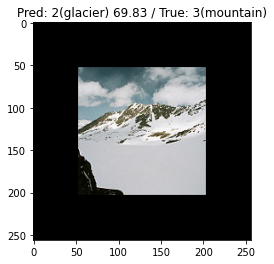

Predicted probability:
[0.01228235 0.03172131 0.51547116 0.3660707  0.05918982 0.01526467]


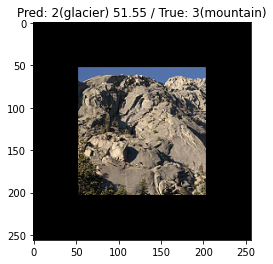

Category: sea
 True predicted images/total sea category: 128 / 150
Predicted probability:
[0.00911764 0.00713744 0.06527322 0.06362095 0.8446117  0.01023903]


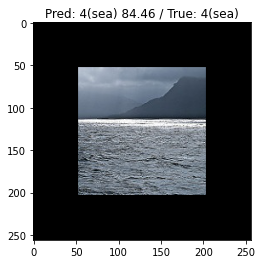

Predicted probability:
[1.1914130e-04 3.8092028e-05 8.8342687e-04 8.7884150e-04 9.9797261e-01
 1.0789351e-04]


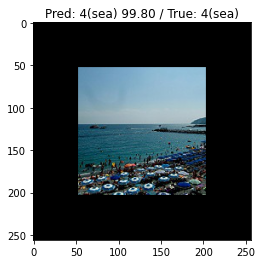

 False predicted images/total sea category: 22 / 150
Predicted probability:
[0.02218648 0.02345664 0.3800026  0.25007847 0.2918979  0.03237791]


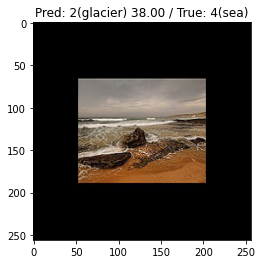

Predicted probability:
[0.17719887 0.0491315  0.1869757  0.28424174 0.20011765 0.10233454]


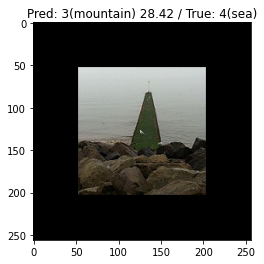

Category: street
 True predicted images/total street category: 129 / 150
Predicted probability:
[2.2102891e-02 2.4628080e-03 1.5179424e-03 9.6700503e-04 1.2109716e-03
 9.7173840e-01]


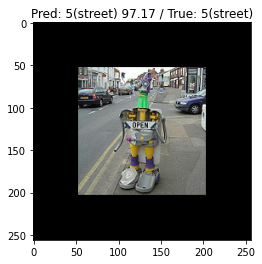

Predicted probability:
[3.1969178e-02 4.0455000e-03 2.0138584e-03 9.5967622e-04 1.1627811e-03
 9.5984900e-01]


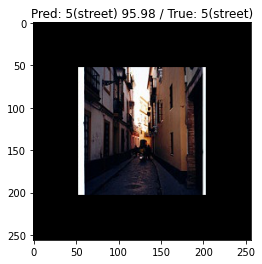

 False predicted images/total street category: 21 / 150
Predicted probability:
[0.7579274  0.0079089  0.00370565 0.00245982 0.0074439  0.22055434]


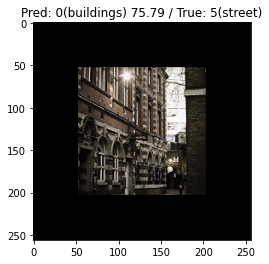

Predicted probability:
[0.78579247 0.00335798 0.00196474 0.00170809 0.00326491 0.2039118 ]


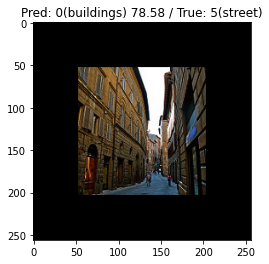

In [ ]:
utils.VisTFPred(test_batch, model, test_data.classes, batch_size, i_n=2)